In [2]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))

Number of training Samples: 405
Number of validation Samples: 102


#### Models:

| Model | Description | Filename |
|:------|------|--|
|   UNet_Mask  | Unet- Model trained on Handlabeled Mask-Data 'train_df'| unet1024_60epochs.h5 |
|   UNet_Circle  | Unet- Model trained on Handlabeled Mask-Data 'train_df'| - |

In [18]:
imgs = os.listdir(DATA_BASE_PATH+"/02_test/images")
files = {"image_path":DATA_BASE_PATH+"/02_test/images/",
             "name":imgs}
test_field_df = pd.DataFrame.from_dict(files)
test_field_df.sample(2)

image_path          name
143  ../data/02_test/images/  P1170165.JPG
76   ../data/02_test/images/  P1170139.JPG

## 1. Unet_Vanilla

In [7]:
# tbd...

## 2. Unet_Pretrained:

Load Model with Pretrained vgg19 encoder on ImageNet and Finetuned on own Blacken-Dataset:

In [8]:
from imports.models.losses import bce_dice_loss, dice_coeff, iou
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/vgg19_coordconv/unet_vgg19_dice_0.8017_iou_0.6732.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

In [9]:
vis_params = {'df':train_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

vis = Visualize(**vis_params)
img = vis.get_image(train_df["name"].sample(1).values[0])

In [10]:
from keras.models import Model
model.layers[0]
model2 = Model(inputs=model.layers[0].input, outputs=model.layers[1].output)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 512, 768, 3)       0         
_________________________________________________________________
coordinate_channel2d_6 (Coor (None, 512, 768, 5)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


(1, 512, 768, 5)


-1.0

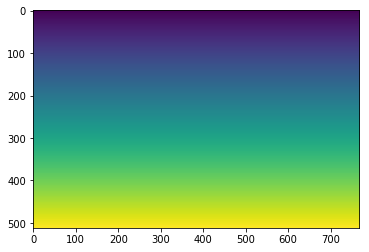

In [12]:
tmp = model2.predict(img.reshape(1,512,768,3))
print(tmp.shape)
imshow(tmp[:,:,:,3].reshape(512,768))
tmp.min()

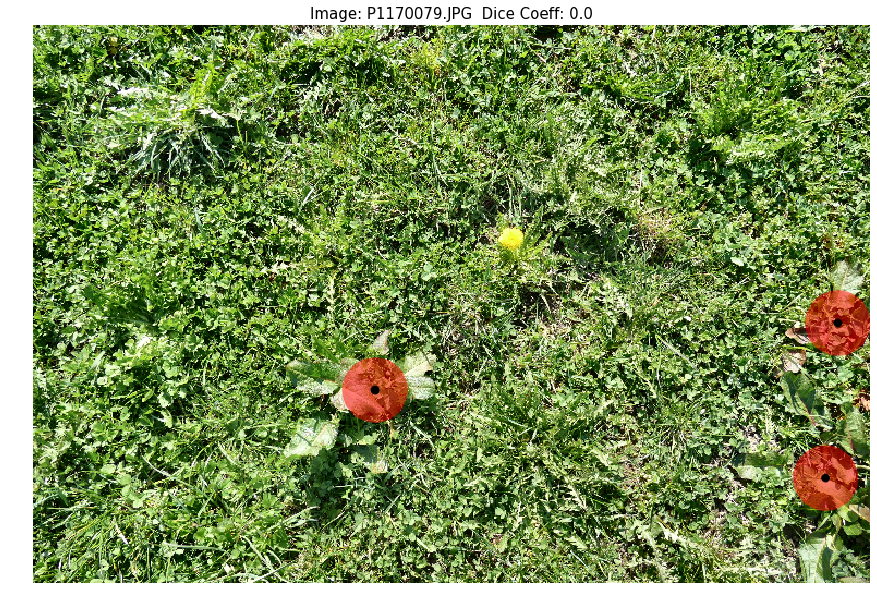

In [19]:
vis_params = {'df':test_field_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

visualize = Visualize(**vis_params)

#img_1358
#1237
#1326
#0143
#155131
#0087
#0120
#0079
#0055
visualize.show_single("0079","image_prediction_roots")

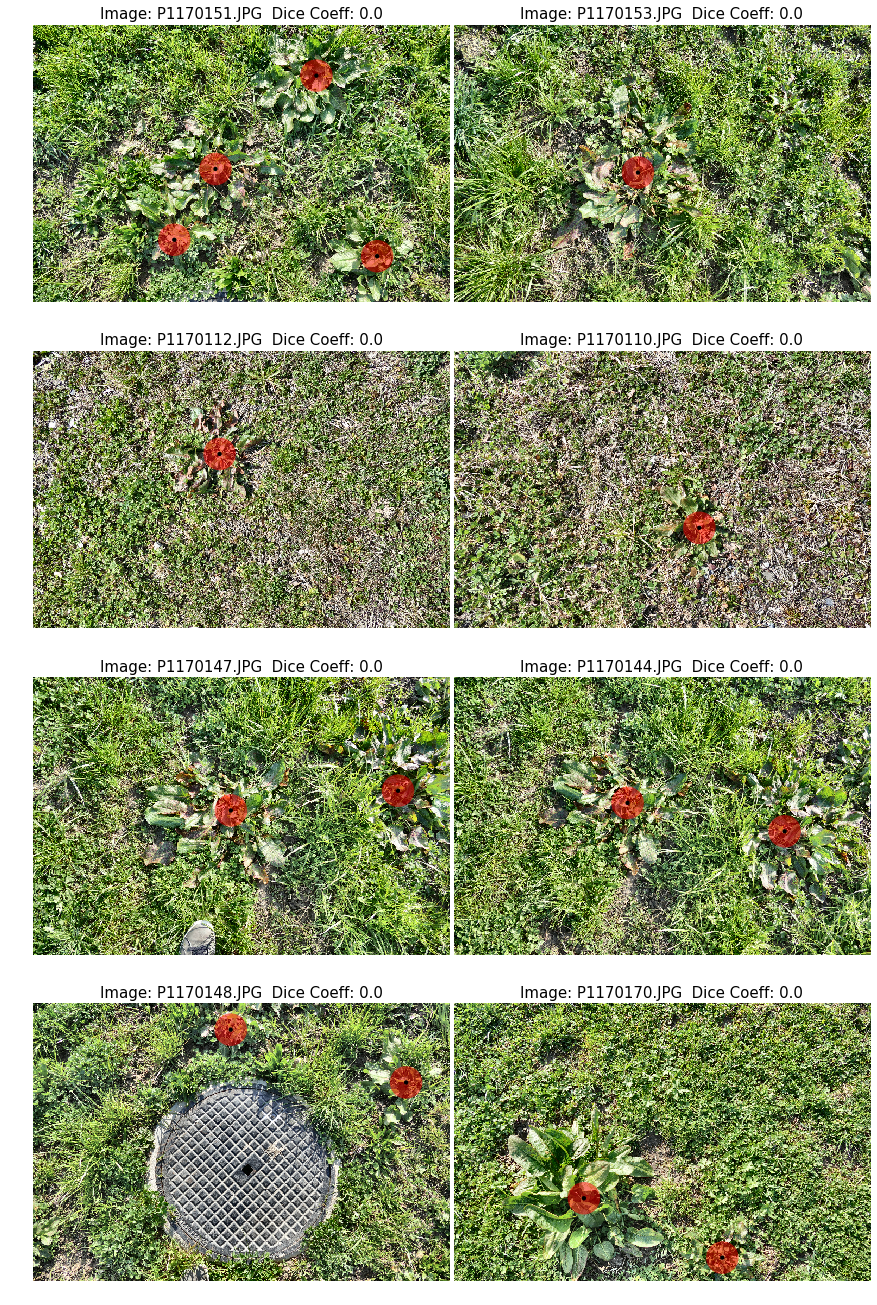

In [20]:
visualize.show_matrix("random","image_prediction_roots",rows=6)

In [10]:
# Set Tolerance Radius:
tolerance = 30

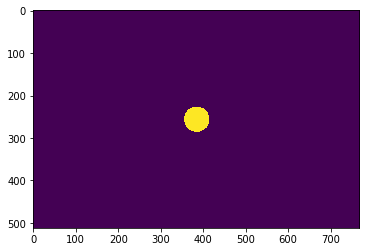

In [11]:
from skimage.draw import circle
img = np.zeros((512, 768), dtype=np.uint8)
rr, cc = circle(512/2, 768/2, tolerance)
img[rr, cc] = 1
imshow(img)

### Accuracy on Validation Set

In [85]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 2,
             'model':model}
ev = Evaluate(**ev_params)

tPs = []
fPs = []
fNs = []
precicions = []
recalls = []
val_log = []
for roots_per_image in range(1,7):
    print("Max roots_per_image: " + str(roots_per_image))
    print("TP\tFP\tFN\tPrecicion\tRecall\tImageName")
    for i,row in val_df.iterrows():
        if len(row["roots"]) <= roots_per_image:
            #print(len(row["roots"]))
            tP, fP, fN, precicion, recall = ev.get_root_precicion_v2(row["name"],tolerance=tolerance)
            print("{}\t{}\t{}\t{:1.2f}\t{:1.2f}\t{}".format(tP, fP, fN, precicion, recall, row['name']))
            tPs.append(tP)
            fPs.append(fP)
            fNs.append(fN)
            precicions.append(precicion)
            recalls.append(recall)
    val_log.append((tPs,fPs,fNs,precicions,recalls))
    tPs = []
    fPs = []
    fNs = []
    precicions = []
    recalls = []

Max roots_per_image: 1
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1232.png
1	1	0	0.50	1.00	img_1023.png
1	0	0	1.00	1.00	img_1484.png
1	0	0	1.00	1.00	img_1077.png
1	0	0	1.00	1.00	img_1273.png
1	1	0	0.50	1.00	img_1295.png
1	0	0	1.00	1.00	img_1318.png
1	0	0	1.00	1.00	img_1274.png
1	0	0	1.00	1.00	img_1260.png
1	0	0	1.00	1.00	img_1088.png
1	0	0	1.00	1.00	img_1364.png
1	0	0	1.00	1.00	img_1320.png
1	0	0	1.00	1.00	img_1100.png
1	0	0	1.00	1.00	img_1434.png
1	0	0	1.00	1.00	img_1299.png
1	0	0	1.00	1.00	img_1002.png
1	1	0	0.50	1.00	img_1174.png
1	0	0	1.00	1.00	img_1275.png
1	0	0	1.00	1.00	img_1089.png
1	0	0	1.00	1.00	img_1183.png
1	0	0	1.00	1.00	img_1107.png
1	0	0	1.00	1.00	img_1053.png
1	0	0	1.00	1.00	img_1136.png
1	0	0	1.00	1.00	img_1047.png
1	0	0	1.00	1.00	img_1411.png
1	0	0	1.00	1.00	img_1110.png
1	0	0	1.00	1.00	img_1466.png
1	0	0	1.00	1.00	img_1004.png
1	0	0	1.00	1.00	img_1384.png
1	0	0	1.00	1.00	img_1393.png
1	0	0	1.00	1.00	img_1086.png
1	0	0	1.00	1.00	img_1454.png
1	0	0	1.00	1.

2	0	0	1.00	1.00	img_1327.png
3	0	0	1.00	1.00	img_1243.png
2	0	1	1.00	0.67	img_1335.png
2	0	0	1.00	1.00	img_1340.png
1	0	0	1.00	1.00	img_1213.png
1	0	0	1.00	1.00	img_1424.png
1	1	3	0.50	0.25	img_1167.png
1	0	1	1.00	0.50	img_1173.png
1	1	0	0.50	1.00	img_1125.png
1	0	0	1.00	1.00	img_1246.png
2	0	0	1.00	1.00	img_1229.png
Max roots_per_image: 5
TP	FP	FN	Precicion	Recall	ImageName
1	0	0	1.00	1.00	img_1232.png
1	1	0	0.50	1.00	img_1023.png
1	0	0	1.00	1.00	img_1484.png
1	0	3	1.00	0.25	img_1182.png
2	0	2	1.00	0.50	img_1270.png
0	0	0	0.00	0.00	img_1083.png
2	0	0	1.00	1.00	img_1446.png
1	0	0	1.00	1.00	img_1172.png
1	0	1	1.00	0.50	img_1014.png
1	0	0	1.00	1.00	img_1077.png
1	0	1	1.00	0.50	img_1339.png
0	0	0	0.00	0.00	img_1096.png
1	0	1	1.00	0.50	img_1091.png
1	0	0	1.00	1.00	img_1273.png
2	0	0	1.00	1.00	img_1448.png
2	0	1	1.00	0.67	img_1398.png
1	1	2	0.50	0.33	img_1450.png
1	1	0	0.50	1.00	img_1295.png
2	0	3	1.00	0.40	img_1476.png
1	0	1	1.00	0.50	img_1238.png
1	0	0	1.00	1.00	img_1318.png
1	0	0	1.00	1.

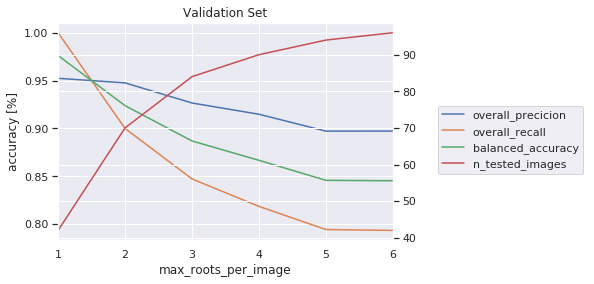

Balanced Accuracy: 0.8453125000000001%


In [86]:
results = {"max_roots_per_image":range(1,len(val_log)+1),
           "true_positive_rate":"pass",
             "overall_precicion":[sum(p[3])/len(p[3]) for p in val_log],
             "overall_recall":[sum(p[4])/len(p[4]) for p in val_log],
             "balanced_accuracy": list((np.asarray([sum(p[3])/len(p[3]) for p in val_log]) + np.asarray([sum(p[4])/len(p[4]) for p in val_log]))/2),
            "n_tested_images":[len(p[0]) for p in val_log]}
test_field_df = pd.DataFrame.from_dict(results)
test_field_df

sns.set(style="darkgrid")
ax = test_field_df[['max_roots_per_image','overall_precicion','overall_recall','balanced_accuracy']].plot(x='max_roots_per_image',legend=False, title='Validation Set')
ax2 = ax.twinx()
ax.set_ylabel("accuracy [%]")
test_field_df[['max_roots_per_image','n_tested_images']].plot(x='max_roots_per_image',y='n_tested_images', ax=ax2, legend=False, color="r")
ax.figure.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

print("Balanced Accuracy: " + str(results['balanced_accuracy'][-1]) + "%")

### Dice Coeff on Validation Set:

In [37]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 1,
             'model':model}
ev = Evaluate(**ev_params)

unet_mask_dice_min, unet_mask_dice_max, unet_mask_dice_avg = ev.get_dice_coeff_score(mode='simple')

print("Average Dice Coefficient: %f" % unet_mask_dice_avg)
print("Min Dice Coefficient: %f" % unet_mask_dice_min)
print("Max Dice Coefficient: %f" % unet_mask_dice_max)

Average prediction time: 0.13 s
Average Dice Coefficient: 0.833286
Min Dice Coefficient: 0.232035
Max Dice Coefficient: 0.952830


### IoU Score on Validation Set:

In [38]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 1,
             'model':model}
ev = Evaluate(**ev_params)

unet_mask_iou_min, unet_mask_iou_max, unet_mask_iou_avg = ev.get_iou_score()

print("Average IoU Coefficient: %f" % unet_mask_iou_avg)
print("Min IoU Coefficient: %f" % unet_mask_iou_min)
print("Max IoU Coefficient: %f" % unet_mask_iou_max)

Average IoU Coefficient: 0.728467
Min IoU Coefficient: 0.131244
Max IoU Coefficient: 0.909910


## Tests

In [110]:
img = visualize.get_mask("img_1253")
test = np.zeros((*img.shape,3))
test[:,:,0] = img
test[:,:,1] = img
test[:,:,2] = img

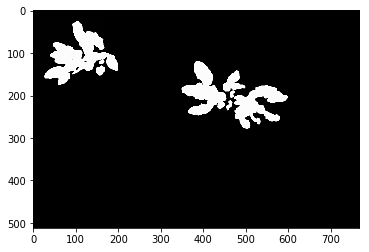

In [113]:
import cv2
shift = cv2.pyrMeanShiftFiltering((test*255).astype("uint8"),80,80)
imshow(shift)

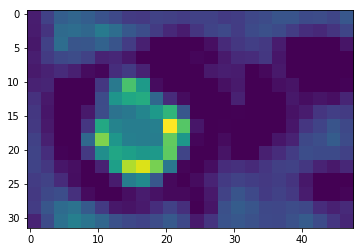

In [113]:
last_conv_layer = model.get_layer("decoder_stage0_upsample")
grads = K.gradients(model.output,last_conv_layer.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img.reshape(1,*SHAPE,3)])

for i in range(2048):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
imshow(heatmap)

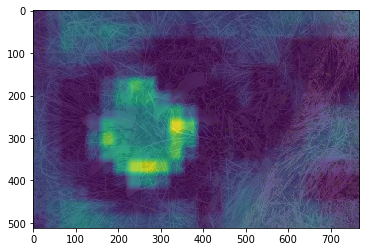

In [109]:
import cv2
heatmap = cv2.resize(heatmap,(768,512))
imshow(img)
imshow(heatmap,alpha=0.8)

In [43]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=test.output)
pred = activation_model.predict(img.reshape(1,*SHAPE,3))


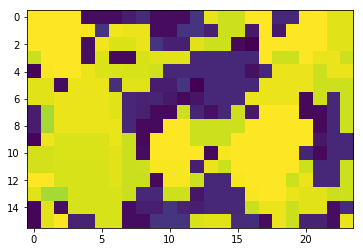

In [44]:
new = np.argmax(pred,axis=3)
new.shape
imshow(new.reshape(16,24))

In [11]:
val_df.sample(1)

image_path              mask_path  \
3  ../data/00_all/images/  ../data/00_all/masks/   

                mask_cirlce_path          name dataset  \
3  ../data/00_all/masks_autogen/  img_1027.png    None   

                                            mask_rle  \
3  183828 2 183866 5 185359 12 185397 15 186895 1...   

                                     mask_circle_rle  \
3  1214047 81 1218628 135 1223218 171 1227811 201...   

                                     roots  \
3  [[727.95439374457, 416.30937997698504]]   

                                             splines  
3  [[[451.7750102519548, 197.76609804372842], [55...

In [11]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

visualize = Visualize(**vis_params)
#img_1358

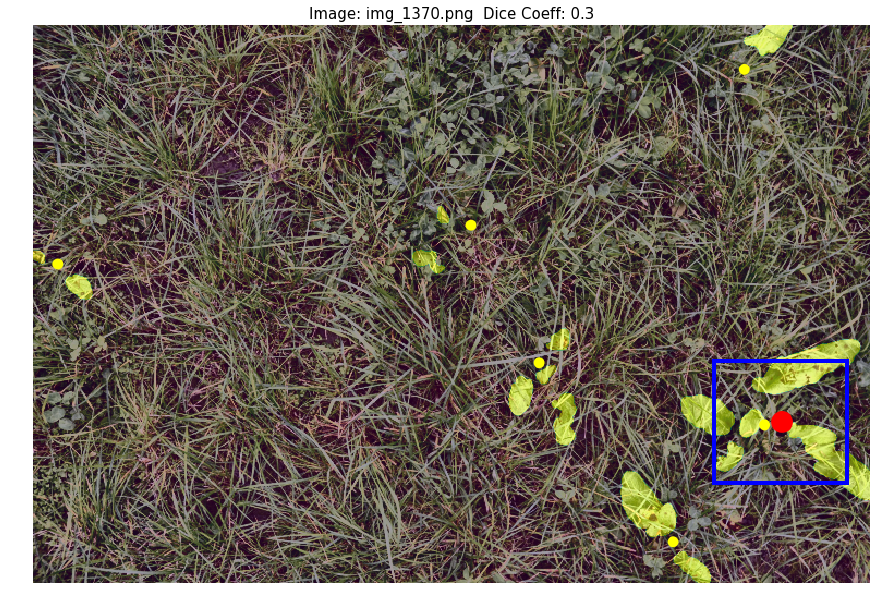

In [12]:
visualize.show_single("img_1370",mode="image_prediction_roots")

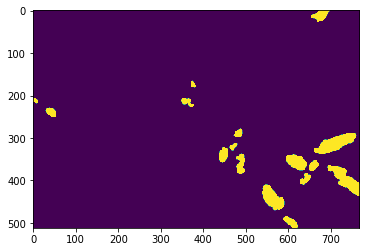

In [13]:
imshow(visualize.get_mask("img_1370"))

In [14]:
pred = visualize.get_prediction("img_1049")

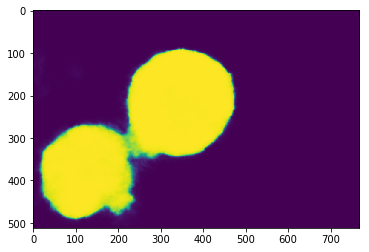

In [15]:
imshow(pred)

In [16]:
import cv2
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 1500
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01
 
# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

In [24]:
# Detect blobs.
new_pred = (pred*255).astype("uint8")
keypoints = detector.detect(open_cv_image)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob

#im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

IndexError: too many indices for array

In [22]:
keypoints

[]

In [91]:
import cv2 as cv
# noise removal
new_pred = (pred*255).astype("uint8")
ret, thresh = cv.threshold(new_pred,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)


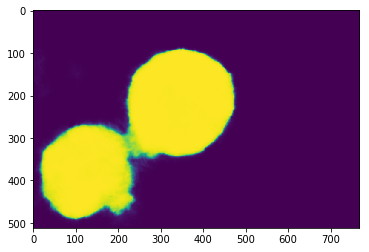

In [23]:
imshow(new_pred)